In [3]:
import numpy as np
import pandas as pd
import os
import random
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [8]:
class MLP:
    def __init__(self, batch_size, alpha, epochs, no_neurons, use_sigmoid: bool):
        self.batch_size = batch_size
        self.use_sigmoid = use_sigmoid
        self.batches = math.floor(410 / batch_size)
        self.alpha = alpha
        self.epochs = epochs
        self.W0 = np.array([[random.randint(0, 10) / 10 for y in range(0, no_neurons)] for x in range(0, 2)])
        self.W1 = np.array([[random.randint(0, 10) / 10 for y in range(0, no_neurons)] for x in range(0, no_neurons)])
        self.W2 = np.array([[random.randint(0, 10) / 10] for x in range(0, no_neurons)])
        self.bias0 = np.array([[0.1 for x in range(0, no_neurons)]])
        self.bias1 = np.array([[0.1 for x in range(0, no_neurons)]])
        self.bias2 = 0.1
        self.Loss_Function = []
        self.iteration_n = []
        data = pd.read_csv('data/HW3Atrain.csv')
        test = pd.read_csv('data/HW3Avalidate.csv')
        x = data.iloc[:, 0:2]
        x_test = test.iloc[:, 0:2]
        self.Y_test = test.iloc[:, -1]
        self.Y = data.iloc[:, -1]
        x = self.min_max_scale(x)
        x_t = self.min_max_scale(x_test)
        self.X_array_test = np.array(x_t)
        self.X_array = np.array(x)

        self.loss_epochs = []; self.loss_val_epochs = []; self.gradient_W2 = []; self.gradient_W1 = []; self.gradient_W0 = []
        self.gradient_b2 = []; self.gradient_b1 = []; self.gradient_b0 = []; self.loss_function = []; self.loss_function_val = []
        self.avg_gradient_W2 = np.ndarray([]); self.avg_gradient_W1 = np.ndarray([]); self.avg_gradient_W0 = np.ndarray([])
        self.avg_gradient_b2 = np.ndarray([]); self.avg_gradient_b1 = np.ndarray([]); self.avg_gradient_b0 = np.ndarray([])
        self.final_W2 = np.ndarray([]); self.final_W1 = np.ndarray([]); self.final_W0 = np.ndarray([])
        self.final_bias0 = np.array([]); self.final_bias1 = np.array([]); self.final_bias2 = np.array([])
        self.results = np.ndarray([]); self.confusion_matrix = np.ndarray([]); self.results_data_frame = pd.DataFrame()
        self.confusion_matrix_data_frame = pd.DataFrame()
        

    def cross_entropy(self, y_hat, y):
        return -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def sigmoid(self, z):
        result = 1.0 / (1.0 + np.exp(-z))
        return result

    def relu_derivative(self, z):
        result = 1 * (z > 0)
        return result

    def relu(self, z):
        if np.isscalar(z):
            result = np.max((z, 0))
        else:
            zero_aux = np.zeros(z.shape)
            meta_z = np.stack((z, zero_aux), axis=-1)
            result = np.max(meta_z, axis=-1)
        return result

    def min_max_scale(self, x):
        x_array = np.array(x)
        for i in range(0, x.shape[1]):
            x_min = np.amin(x.iloc[:, i])
            x_max = np.amax(x.iloc[:, i])
            scale = x_max - x_min
            for j in range(0, x.shape[0]):
                x_array[j, i] = x.iloc[j, i] / scale - x_min / scale
        return x_array

    def train(self):
        avg_loss_function_epoch = []
        avg_loss_function_val_epoch = []
        self.loss_epochs = []
        self.loss_val_epochs = []
        for epoch in range(0, self.epochs):
            self.loss_epochs.append(np.mean(avg_loss_function_epoch))
            self.loss_val_epochs.append(np.mean(avg_loss_function_val_epoch))  
            if epoch != 0:
                print(f"\nAVG_LOSS_FUNCTION OF EPOCH {epoch} ON TRAINING SET: {np.mean(avg_loss_function_epoch)}")
                print(f"\nAVG_LOSS_FUNCTION OF EPOCH {epoch} ON VALIDATION SET: {np.mean(avg_loss_function_val_epoch)}")
            avg_loss_function_epoch = []
            avg_loss_function_val_epoch = []
            for batch in range(0, self.batches):
                self.gradient_W2 = []; self.gradient_W1 = []; self.gradient_W0 = []; self.gradient_b2 = []
                self.gradient_b1 = []; self.gradient_b0 = []; self.avg_gradient_W2 = []; self.avg_gradient_W1 = []
                self.avg_gradient_W0 = []; self.avg_gradient_b2 = []; self.avg_gradient_b1 = []; self.avg_gradient_b0 = []
                self.loss_function = []; self.loss_function_val = []; self.loss_function_epoch = []
                avg_loss_function = []; avg_loss_function_val = []
                
                start_at = batch * self.batch_size
                for i in range(start_at, start_at + self.batch_size):
                    x_input = self.X_array[[i]]
                    y_input = self.Y[i]
                    self.iteration(x_input, i, y_input)
                    if (i < 82) & (batch<=(82/self.batch_size)):
                        x_t_input = self.X_array_test[[i]]
                        y_t_input = self.Y_test[i]
                        self.iteration_val(x_t_input, i, y_t_input)

                # Calculating average of Loss Function for this batch
                avg_loss_function = sum(self.loss_function) / self.batch_size  # this is the loss function of the batch
                avg_loss_function_val = sum(self.loss_function_val) / self.batch_size
                avg_loss_function_epoch.append(avg_loss_function)  # we add it to the list of epoch's loss functions
                if batch<=(82/self.batch_size):
                    avg_loss_function_val_epoch.append(avg_loss_function_val)
                
                
                # Calculating average of all gradients of this batch
                self.avg_gradient_W2 = np.mean(self.gradient_W2, axis=0)
                self.avg_gradient_W1 = np.mean(self.gradient_W1, axis=0)
                self.avg_gradient_W0 = np.mean(self.gradient_W0, axis=0)
                self.avg_gradient_b2 = np.mean(self.gradient_b2, axis=0)
                self.avg_gradient_b1 = np.mean(self.gradient_b1, axis=0)
                self.avg_gradient_b0 = np.mean(self.gradient_b0, axis=0)

                # Updating Weights and Biases
                new_w2 = self.W2 - self.alpha * self.avg_gradient_W2
                new_b2 = self.bias2 - self.alpha * self.avg_gradient_b2
                new_w1 = self.W1 - self.alpha * self.avg_gradient_W1
                new_b1 = self.bias1 - self.alpha * self.avg_gradient_b1
                new_w0 = self.W0 - self.alpha * self.avg_gradient_W0
                new_b0 = self.bias0 - self.alpha * self.avg_gradient_b0
                self.W2 = new_w2
                self.W1 = new_w1
                self.W0 = new_w0
                self.bias2 = new_b2
                self.bias1 = new_b1
                self.bias0 = new_b0
                self.final_W2 = new_w2
                self.final_W1 = new_w1
                self.final_W0 = new_w0
                self.final_bias2 = new_b2
                self.final_bias1 = new_b1
                self.final_bias0 = new_b0


    def iteration(self, x_input, i, y_input):
        # Feed Forward + Gradient calculation for each training datapoint
        input_h0 = x_input.dot(self.W0) + self.bias0
        output_h0 = self.sigmoid(input_h0) if self.use_sigmoid else self.relu(input_h0)
        input_h1 = output_h0.dot(self.W1) + self.bias1
        output_h1 = self.sigmoid(input_h1) if self.use_sigmoid else self.relu(input_h1)
        input_sigmoid = output_h1.dot(self.W2) + self.bias2
        y_hat = self.sigmoid(input_sigmoid)

        # Calculating the Loss Function for this data point and adding it to the batch's loss
        self.loss_function.append(self.cross_entropy(y_hat, y_input))

        # Back Propagation - Calculating derivatives
        derivative_cross_entropy = -1 * (y_input / y_hat) + ((1 - y_input) / (1 - y_hat))
        derivative_sigmoid = y_hat * (1 - y_hat)
        if self.use_sigmoid:
            self.gradient_W2.append((derivative_cross_entropy * derivative_sigmoid * output_h1).T)
            self.gradient_W1.append(derivative_cross_entropy * derivative_sigmoid * self.W2.T * (output_h1 * (1 - output_h1)) * output_h0.T)
            self.gradient_W0.append(derivative_cross_entropy * derivative_sigmoid * (output_h1 * (1 - output_h1)) * self.W2.T.dot(self.W1.T) * (output_h0 * (1 - output_h0)) * x_input.T)
            self.gradient_b2.append(derivative_cross_entropy * derivative_sigmoid)
            self.gradient_b1.append(derivative_cross_entropy * derivative_sigmoid * self.W2.T * (output_h1 * (1 - output_h1)))
            self.gradient_b0.append(derivative_cross_entropy * derivative_sigmoid * (output_h1 * (1 - output_h1)) * self.W2.T.dot(self.W1.T) * (output_h0 * (1 - output_h0)))
        else:
            self.gradient_W2.append((derivative_cross_entropy * derivative_sigmoid * output_h1).T)
            self.gradient_W1.append(derivative_cross_entropy * derivative_sigmoid * self.W2.T *self.relu_derivative(input_h1) * output_h0.T)
            self.gradient_W0.append(derivative_cross_entropy * derivative_sigmoid *self.relu_derivative(input_h1) * self.W2.T.dot(self.W1.T) * self.relu_derivative(input_h0) * x_input.T)
            self.gradient_b2.append(derivative_cross_entropy * derivative_sigmoid)
            self.gradient_b1.append(derivative_cross_entropy * derivative_sigmoid *self.W2.T * self.relu_derivative(input_h1))
            self.gradient_b0.append(derivative_cross_entropy * derivative_sigmoid *self.relu_derivative(input_h1) * self.W2.T.dot(self.W1.T) * self.relu_derivative(input_h0))

    def predict(self) -> float:
        self.results = np.empty([self.X_array_test.shape[0], 7])
        self.confusion_matrix = np.empty([2, 2])
        for i in range(0, self.X_array_test.shape[0]):
            x_t_input = self.X_array_test[[i]]
            y_t_input = self.Y_test[i]
            self.iteration_ff(x_t_input, i, y_t_input)
        self.results_data_frame = pd.DataFrame(self.results)
        self.results_data_frame.columns = ('X0', 'X1', 'Y true', 'Y pred.', 'Cost', 'Prediction', 'Correct?')
        accuracy = sum(self.results_data_frame.iloc[:, 6]) / self.X_array_test.shape[0]
        avg_cost = np.mean(self.results_data_frame.iloc[:, 4])
        self.confusion_matrix[0, 0] = sum((self.results_data_frame.iloc[:, 2] == 1) & (self.results_data_frame.iloc[:, 5] == 1))
        self.confusion_matrix[0, 1] = sum((self.results_data_frame.iloc[:, 2] == 1) & (self.results_data_frame.iloc[:, 5] == 0))
        self.confusion_matrix[1, 0] = sum((self.results_data_frame.iloc[:, 2] == 0) & (self.results_data_frame.iloc[:, 5] == 1))
        self.confusion_matrix[1, 1] = sum((self.results_data_frame.iloc[:, 2] == 0) & (self.results_data_frame.iloc[:, 5] == 0))
        self.confusion_matrix_data_frame = pd.DataFrame(self.confusion_matrix).astype(int)
        self.confusion_matrix_data_frame.columns = ('Predicted Class= 1','Predicted Class= 0')
        self.confusion_matrix_data_frame.index = ('True Class= 1', 'True Class= 0')
        dict1 = {1.0: "Yes", 0.0: "No"}
        self.results_data_frame.iloc[:, 6].replace(dict1, inplace=True)
        print(self.results_data_frame)
        print(f"\n ACCURACY: {accuracy * 100} %")
        print(f"\n AVERAGE COST FUNCTION: {round(avg_cost, 4)}")
        print(f"\n --------------- \n\nCONFUSION MATRIX \n")
        print(self.confusion_matrix_data_frame)
        return accuracy

    def iteration_ff(self, x_t_input, i, y_t_input):
        input_h0 = x_t_input.dot(self.final_W0) + self.final_bias0
        output_h0 = self.sigmoid(input_h0) if self.use_sigmoid else self.relu(input_h0)
        input_h1 = output_h0.dot(self.final_W1) + self.final_bias1
        output_h1 = self.sigmoid(input_h1) if self.use_sigmoid else self.relu(input_h1)
        input_sigmoid = output_h1.dot(self.final_W2) + self.final_bias2
        y_hat = self.sigmoid(input_sigmoid)
        
        self.results[i, 0] = round(x_t_input[0][0], 3)
        self.results[i, 1] = round(x_t_input[0][1], 3)
        self.results[i, 2] = y_t_input
        self.results[i, 3] = round(y_hat[0][0], 3)
        self.results[i, 4] = round(self.cross_entropy(y_hat, y_t_input)[0][0], 3)
        if y_hat[0][0] > 0.5:
            self.results[i, 5] = 1
        else:
            self.results[i, 5] = 0
        if self.results[i, 2] == self.results[i, 5]:
            self.results[i, 6] = 1
        else:
            self.results[i, 6] = 0
    
    def iteration_val(self, x_t_input, i, y_t_input): #this function computes the loss on the validation datapoints
        input_h0 = x_t_input.dot(self.W0) + self.bias0
        output_h0 = self.sigmoid(input_h0) if self.use_sigmoid else self.relu(input_h0)
        input_h1 = output_h0.dot(self.W1) + self.bias1
        output_h1 = self.sigmoid(input_h1) if self.use_sigmoid else self.relu(input_h1)
        input_sigmoid = output_h1.dot(self.W2) + self.bias2
        y_hat = self.sigmoid(input_sigmoid)
        if i<82:
            self.loss_function_val.append(self.cross_entropy(y_hat, y_t_input)[0][0])

In [9]:
HW3 = MLP(batch_size=10, alpha=0.05, epochs=200, no_neurons=10, use_sigmoid=False)

In [10]:
HW3.train()


AVG_LOSS_FUNCTION OF EPOCH 1 ON TRAINING SET: 1.2043628395156292

AVG_LOSS_FUNCTION OF EPOCH 1 ON VALIDATION SET: 1.991595507882447

AVG_LOSS_FUNCTION OF EPOCH 2 ON TRAINING SET: 0.7432229410096723

AVG_LOSS_FUNCTION OF EPOCH 2 ON VALIDATION SET: 0.6966413802790484

AVG_LOSS_FUNCTION OF EPOCH 3 ON TRAINING SET: 0.7226801100816115

AVG_LOSS_FUNCTION OF EPOCH 3 ON VALIDATION SET: 0.6665485632281763

AVG_LOSS_FUNCTION OF EPOCH 4 ON TRAINING SET: 0.7096630697176222

AVG_LOSS_FUNCTION OF EPOCH 4 ON VALIDATION SET: 0.6515324623435496

AVG_LOSS_FUNCTION OF EPOCH 5 ON TRAINING SET: 0.6985833834274693

AVG_LOSS_FUNCTION OF EPOCH 5 ON VALIDATION SET: 0.6407590000796285

AVG_LOSS_FUNCTION OF EPOCH 6 ON TRAINING SET: 0.6871968611075108

AVG_LOSS_FUNCTION OF EPOCH 6 ON VALIDATION SET: 0.6306835425967168

AVG_LOSS_FUNCTION OF EPOCH 7 ON TRAINING SET: 0.674595940298868

AVG_LOSS_FUNCTION OF EPOCH 7 ON VALIDATION SET: 0.6196432455390736

AVG_LOSS_FUNCTION OF EPOCH 8 ON TRAINING SET: 0.658371618319429


AVG_LOSS_FUNCTION OF EPOCH 61 ON TRAINING SET: 0.17220245208310606

AVG_LOSS_FUNCTION OF EPOCH 61 ON VALIDATION SET: 0.17200440899724262

AVG_LOSS_FUNCTION OF EPOCH 62 ON TRAINING SET: 0.17219801408338428

AVG_LOSS_FUNCTION OF EPOCH 62 ON VALIDATION SET: 0.1722006662090062

AVG_LOSS_FUNCTION OF EPOCH 63 ON TRAINING SET: 0.172070407381415

AVG_LOSS_FUNCTION OF EPOCH 63 ON VALIDATION SET: 0.17246950462602847

AVG_LOSS_FUNCTION OF EPOCH 64 ON TRAINING SET: 0.17196929761303645

AVG_LOSS_FUNCTION OF EPOCH 64 ON VALIDATION SET: 0.17279788251327335

AVG_LOSS_FUNCTION OF EPOCH 65 ON TRAINING SET: 0.17194451819397066

AVG_LOSS_FUNCTION OF EPOCH 65 ON VALIDATION SET: 0.17314113001101902

AVG_LOSS_FUNCTION OF EPOCH 66 ON TRAINING SET: 0.17176318815877406

AVG_LOSS_FUNCTION OF EPOCH 66 ON VALIDATION SET: 0.17368940115518394

AVG_LOSS_FUNCTION OF EPOCH 67 ON TRAINING SET: 0.17172419114988358

AVG_LOSS_FUNCTION OF EPOCH 67 ON VALIDATION SET: 0.17377459907219042

AVG_LOSS_FUNCTION OF EPOCH 68 ON TRA


AVG_LOSS_FUNCTION OF EPOCH 121 ON TRAINING SET: 0.16378501599307915

AVG_LOSS_FUNCTION OF EPOCH 121 ON VALIDATION SET: 0.17669984184903645

AVG_LOSS_FUNCTION OF EPOCH 122 ON TRAINING SET: 0.16363432510541545

AVG_LOSS_FUNCTION OF EPOCH 122 ON VALIDATION SET: 0.17668464233084397

AVG_LOSS_FUNCTION OF EPOCH 123 ON TRAINING SET: 0.1634872174300828

AVG_LOSS_FUNCTION OF EPOCH 123 ON VALIDATION SET: 0.17685395813117666

AVG_LOSS_FUNCTION OF EPOCH 124 ON TRAINING SET: 0.16333631744909352

AVG_LOSS_FUNCTION OF EPOCH 124 ON VALIDATION SET: 0.1764399133530821

AVG_LOSS_FUNCTION OF EPOCH 125 ON TRAINING SET: 0.16318414815736337

AVG_LOSS_FUNCTION OF EPOCH 125 ON VALIDATION SET: 0.1764197903422113

AVG_LOSS_FUNCTION OF EPOCH 126 ON TRAINING SET: 0.16303386964928482

AVG_LOSS_FUNCTION OF EPOCH 126 ON VALIDATION SET: 0.17641669731755616

AVG_LOSS_FUNCTION OF EPOCH 127 ON TRAINING SET: 0.16290442361838078

AVG_LOSS_FUNCTION OF EPOCH 127 ON VALIDATION SET: 0.1766036210859367

AVG_LOSS_FUNCTION OF EP


AVG_LOSS_FUNCTION OF EPOCH 180 ON TRAINING SET: 0.15647304056019623

AVG_LOSS_FUNCTION OF EPOCH 180 ON VALIDATION SET: 0.17394007187729707

AVG_LOSS_FUNCTION OF EPOCH 181 ON TRAINING SET: 0.15633805968480866

AVG_LOSS_FUNCTION OF EPOCH 181 ON VALIDATION SET: 0.1743091798179572

AVG_LOSS_FUNCTION OF EPOCH 182 ON TRAINING SET: 0.15629722380680974

AVG_LOSS_FUNCTION OF EPOCH 182 ON VALIDATION SET: 0.17385682123863533

AVG_LOSS_FUNCTION OF EPOCH 183 ON TRAINING SET: 0.15615146140592173

AVG_LOSS_FUNCTION OF EPOCH 183 ON VALIDATION SET: 0.17424729926106888

AVG_LOSS_FUNCTION OF EPOCH 184 ON TRAINING SET: 0.1560996782960467

AVG_LOSS_FUNCTION OF EPOCH 184 ON VALIDATION SET: 0.17378939781788957

AVG_LOSS_FUNCTION OF EPOCH 185 ON TRAINING SET: 0.15596638978120886

AVG_LOSS_FUNCTION OF EPOCH 185 ON VALIDATION SET: 0.17418188224019315

AVG_LOSS_FUNCTION OF EPOCH 186 ON TRAINING SET: 0.15591569286854537

AVG_LOSS_FUNCTION OF EPOCH 186 ON VALIDATION SET: 0.1737111289971076

AVG_LOSS_FUNCTION OF E

In [11]:
HW3.predict()

       X0     X1  Y true  Y pred.   Cost  Prediction Correct?
0   0.683  0.796     0.0    0.002  0.002         0.0      Yes
1   0.689  0.394     1.0    0.897  0.108         1.0      Yes
2   0.053  0.621     1.0    0.788  0.239         1.0      Yes
3   0.918  0.753     0.0    0.001  0.001         0.0      Yes
4   0.369  0.075     0.0    0.010  0.010         0.0      Yes
..    ...    ...     ...      ...    ...         ...      ...
77  0.953  0.659     0.0    0.004  0.004         0.0      Yes
78  0.844  0.635     0.0    0.010  0.010         0.0      Yes
79  0.374  0.635     1.0    0.866  0.143         1.0      Yes
80  0.057  0.391     0.0    0.053  0.054         0.0      Yes
81  0.590  0.285     1.0    0.968  0.033         1.0      Yes

[82 rows x 7 columns]

 ACCURACY: 97.5609756097561 %

 AVERAGE COST FUNCTION: 0.1855

 --------------- 

CONFUSION MATRIX 

               Predicted Class= 1  Predicted Class= 0
True Class= 1                  40                   1
True Class= 0          

0.975609756097561

### Plots

In [12]:
Validation_Set = np.empty(HW3.epochs-1)
for i in range (1,HW3.epochs):
    Validation_Set[i-1] = HW3.loss_val_epochs[i]

In [13]:
Training_Set = np.empty(HW3.epochs-1)
for i in range (1,HW3.epochs):
    Training_Set[i-1] = HW3.loss_epochs[i]

In [14]:
epochs = np.arange(HW3.epochs-1)

Text(0, 0.5, 'Avg. Cross-Entropy')

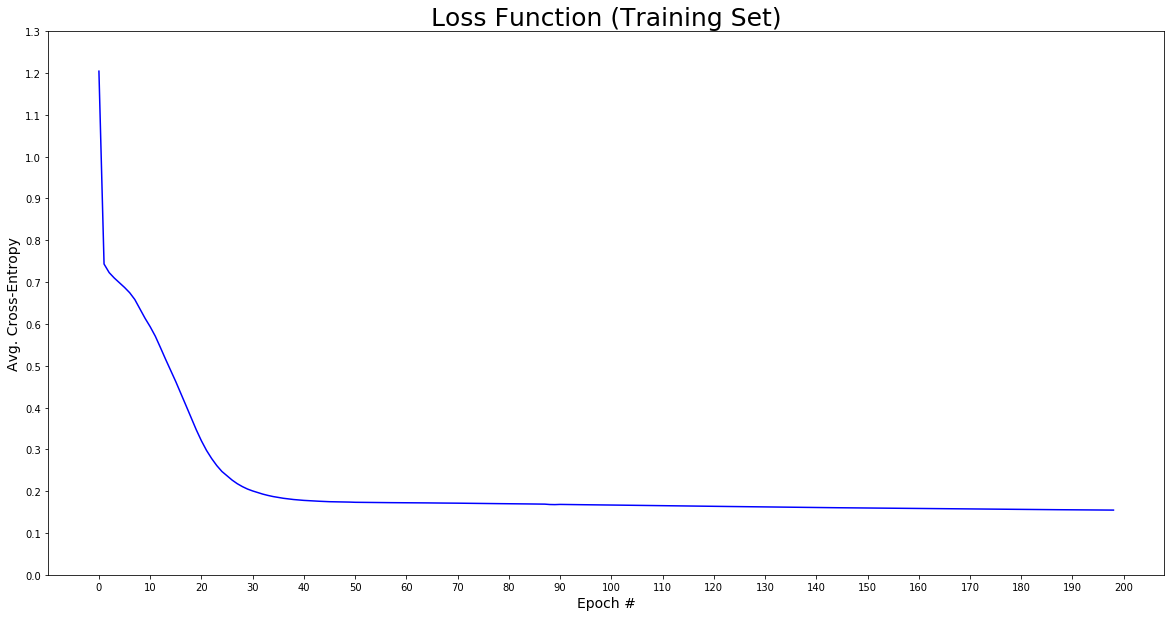

In [18]:
plt.figure(figsize=(20,10))
plt.plot(epochs, Training_Set, color='Blue')
plt.yticks(np.arange(0,1.4,0.1))
plt.xticks(np.arange(0,210,10))
plt.title('Loss Function (Training Set)', fontsize=25)
plt.xlabel('Epoch #', fontsize=14)
plt.ylabel('Avg. Cross-Entropy', fontsize=14)

Text(0, 0.5, 'Avg. Cross-Entropy')

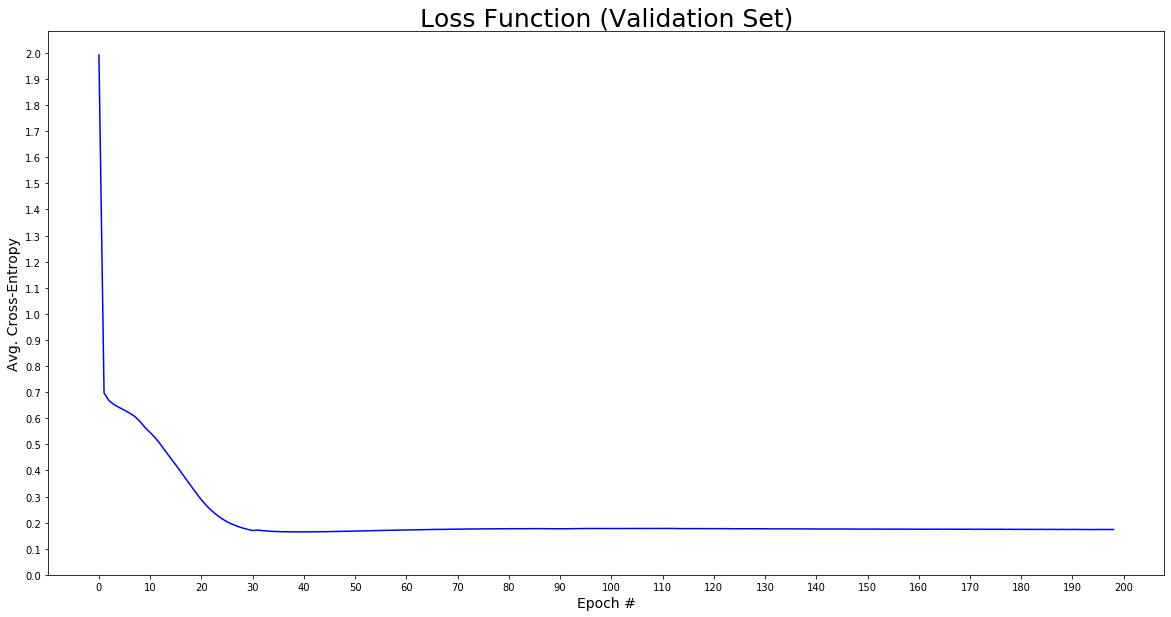

In [19]:
plt.figure(figsize=(20,10))
plt.plot(epochs, Validation_Set, color='Blue')
plt.yticks(np.arange(0,2.1,0.1))
plt.xticks(np.arange(0,210,10))
plt.title('Loss Function (Validation Set)', fontsize=25)
plt.xlabel('Epoch #', fontsize=14)
plt.ylabel('Avg. Cross-Entropy', fontsize=14)